# simulated pump probe for testing ridge, constrained, or more advanced regression

In [229]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import binned_statistic_dd
from scipy.optimize import least_squares

## making simulated data

In [80]:
def y(t,a,w,phi,tau):
    return 50+np.heaviside(t,0)*(-5*np.exp(-t/tau)+a*np.exp(-t/tau)*np.sin(w*t+phi))
    


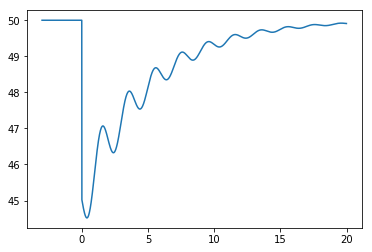

In [81]:
t = np.arange(-3,20,0.01)
plt.plot(t,y(t,1,np.pi,3.1,5))

In [82]:
t_sim     =  np.random.rand(4*len(t))*23-3
e_sim     =  np.random.normal(916,3,len(t_sim))
e_noisy   =  e_sim + np.random.normal(0,1,len(t_sim))
y_sim     =  y(t_sim,1,np.pi,3.1,5) #+np.random.normal(0,1,len(t_sim))
IFEE_sim  =  np.random.rand(len(t_sim))
I0_sim    =  IFEE_sim*np.exp(-(913-e_noisy)**2/4**2)+np.random.normal(0.0,0.2,len(t_sim))**2
I_sim     =  I0_sim*y_sim *10* (1+(e_sim-895)/50.0) +np.random.normal(0,0.8,len(t_sim))**2

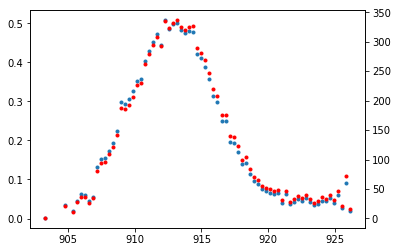

In [83]:
my_bins = np.arange(900,930,0.3)

my_binned_stat = binned_statistic_dd(e_sim,I0_sim,bins=[my_bins],statistic=np.average)
plt.plot(my_binned_stat.bin_edges[0][:-1],my_binned_stat.statistic,'.',alpha=1)
plt.twinx()
my_binned_stat = binned_statistic_dd(e_sim,I_sim,bins=[my_bins],statistic=np.average)
plt.plot(my_binned_stat.bin_edges[0][:-1],my_binned_stat.statistic,'.',alpha=1,color='r')

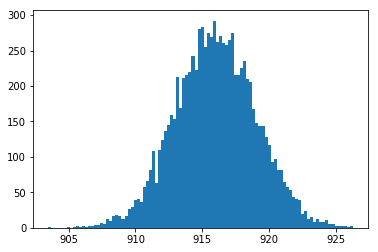

In [84]:
dummy_hist = plt.hist(e_sim,bins=100)

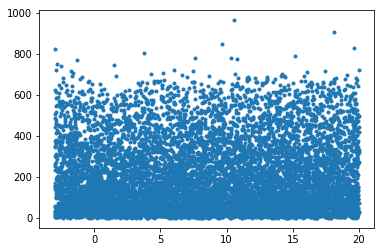

In [85]:
plt.plot(t_sim,I_sim,'.')
plt.show()

## global regression using scipy optimize least squares

In [ ]:
#1) make functions that returns residuals
#2) make function that generates matrices
#3) try objects approach

In [226]:
class global_pump_probe_regression_object():
    def __init__(self):
        self.x       = np.arange(10)
        self.y       = 13*self.x+np.random.rand(10)+5
        
    def f_of_x(self,x0):
        return x0[0]*self.x+ x0[1]
    
    def get_residuals(self,x0):
        return self.y - self.f_of_x(x0)
        

In [227]:
for_scipy_optimize = global_pump_probe_regression_object()

In [233]:
x0 = [12,4]
for_scipy_optimize.y = for_scipy_optimize.x*17-11+np.random.rand(10)
my_least_squares_solution = least_squares(for_scipy_optimize.get_residuals,x0)

In [239]:
my_least_squares_solution

 active_mask: array([0., 0.])
        cost: 0.25538763323840696
         fun: array([-0.27004669,  0.02747303, -0.20613535,  0.41620553,  0.02266849,
        0.34275704,  0.10226921, -0.20433736, -0.22615342, -0.0047005 ])
        grad: array([-2.11175105e-10,  3.23889232e-08])
         jac: array([[ 0.        , -1.        ],
       [-1.        , -1.        ],
       [-2.        , -1.        ],
       [-3.00000001, -1.00000002],
       [-4.        , -1.00000002],
       [-5.00000001, -0.99999998],
       [-5.99999997, -1.00000007],
       [-7.00000004, -1.00000007],
       [-8.        , -1.00000007],
       [-8.99999996, -0.99999998]])
     message: 'Both `ftol` and `xtol` termination conditions are satisfied.'
        nfev: 4
        njev: 4
  optimality: 3.23889231823582e-08
      status: 4
     success: True
           x: array([ 17.02092813, -10.5570986 ])

In [203]:
t_bins = np.arange(-3,20,0.05)
X = np.array([np.ones(len(I_sim)),I0_sim,(I0_sim)*(e_sim-np.mean(e_sim)) ])

In [215]:
def get_residuals(x,*args,**kwargs):
    print(x)
    print(args)
    print(kwargs)
    
    my_digitized = np.digitize(t_sim,t_bins)
    
get_residuals(X,'test',3,my_bins=t_bins)

[[ 1.          1.          1.         ...  1.          1.
   1.        ]
 [ 0.00357133  0.49327587  0.04568856 ...  0.8931258   0.04731648
   0.09209711]
 [ 0.01971022 -0.41202432  0.30881334 ... -2.22681185  0.12351397
  -0.02180618]]
('test', 3)
{'beta': 4}


In [204]:
X.shape

(3, 9200)

In [205]:
my_digitized = np.digitize(t_sim,t_bins)

In [206]:
t_bins.shape

(460,)

In [207]:
X[:,my_digitized]

array([[ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 0.28535855,  0.18456199,  0.08861132, ...,  0.4418975 ,
         0.05769008,  0.24156888],
       [-0.32018644,  0.18196429,  0.01105993, ..., -0.79579146,
        -0.56321662,  0.47371466]])

In [210]:


my_pump_probe = []

residuals_list = []

I_sim_size = 0

for i in set(my_digitized):
    my_mask  = (my_digitized==i)
    
    beta = np.dot(np.linalg.pinv(X.transpose()[my_mask]),I_sim[my_mask])
    
    residuals = (((I_sim[my_mask]-np.dot(X.transpose()[my_mask],np.array([beta]).transpose())[:,0])))
    
    for i in residuals:
        residuals_list.append(i)
    
    I_sim_size = I_sim_size+I_sim[my_mask].shape[0]
    my_pump_probe.append(beta)

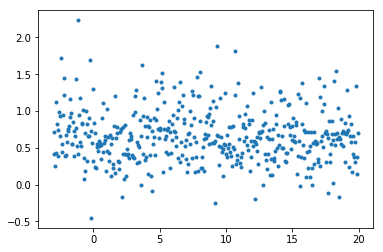

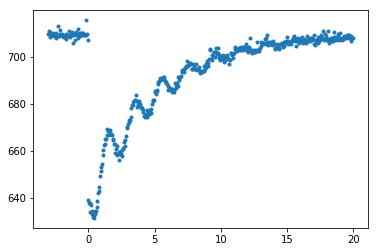

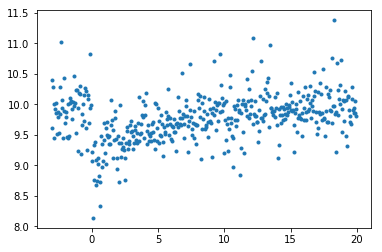

In [212]:
my_pump_probe = np.array(my_pump_probe)
for i in range(X.shape[0]):
    plt.plot(t_bins,my_pump_probe[:,i],'.')
    plt.show()

## standard bin by bin regression

In [168]:
t_bins = np.arange(-3,20,0.05)

my_pump_probe = []

residuals = []

I_sim_size = 0

for i in np.arange(len(t_bins)-1):
    my_mask  = (t_sim >= t_bins[i])
    my_mask *= (t_sim <= t_bins[i+1])
    
    X = np.array([np.ones(np.sum(my_mask)),I0_sim[my_mask]-np.mean(I0_sim[my_mask]),(e_sim[my_mask]-np.mean(e_sim[my_mask])),(I0_sim[my_mask]-np.mean(I0_sim[my_mask]))*(e_sim[my_mask]-np.mean(e_sim[my_mask])) ])
    #X = np.array([np.ones(np.sum(my_mask)),I0_sim[my_mask],(I0_sim[my_mask])*(e_sim[my_mask]-np.mean(e_sim[my_mask])) ])
    beta = np.dot(np.linalg.pinv(X.transpose()),I_sim[my_mask])
    
    residuals.append(list((I_sim[my_mask]-np.dot(X.transpose(),np.array([beta]).transpose())[:,0])))
    I_sim_size = I_sim_size+I_sim[my_mask].shape[0]
    my_pump_probe.append(beta)

In [87]:
my_pump_probe = np.array(my_pump_probe)

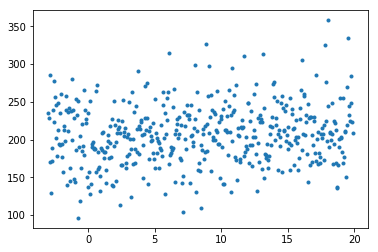

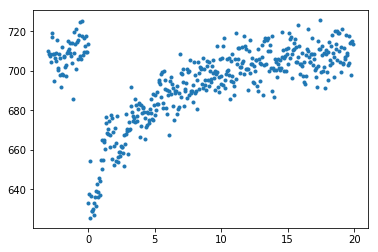

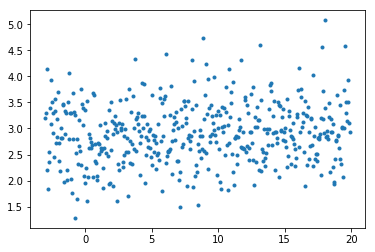

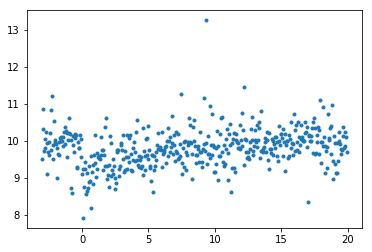

In [88]:
for i in range(X.shape[0]):
    plt.plot(t_bins[:-1],my_pump_probe[:,i],'.')
    plt.show()

## ridge regression

### making big matrix for linearized system


In [108]:
#make giant matrix
t_bins = np.arange(-3,20,0.05)

my_pump_probe = []

big_X = np.zeros([I_sim.shape[0],t_bins.shape[0]*4])
big_Y = np.zeros([I_sim.shape[0],t_bins.shape[0]])

my_col = 0
my_row = 0

my_ycol = 0
my_yrow = 0

for i in np.arange(len(t_bins)-1):
    my_mask  = (t_sim >= t_bins[i])
    my_mask *= (t_sim <= t_bins[i+1])
    
    X = (np.array([np.ones(np.sum(my_mask)),I0_sim[my_mask],(e_sim[my_mask]-np.mean(e_sim[my_mask])),(I0_sim[my_mask]-np.mean(I0_sim[my_mask]))*(e_sim[my_mask]-np.mean(e_sim[my_mask])) ])).transpose()
    Y = I_sim[my_mask]
    
    big_X[my_row:my_row+X.shape[0],my_col:my_col + X.shape[1]] = X
    big_Y[my_yrow:my_yrow+Y.shape[0],my_ycol] = Y
    
    my_col = my_col + X.shape[1]
    my_row = my_row + X.shape[0]
    
    my_ycol = my_ycol + 1
    my_yrow = my_yrow + Y.shape[0]

    
    #beta = np.dot(np.linalg.pinv(X.transpose()),I_sim[my_mask])
    #my_pump_probe.append(beta)

In [109]:
pseudo_inv = np.linalg.pinv(big_X)

## diagonal beta

In [110]:
beta = np.dot(pseudo_inv,big_Y)

In [111]:
beta.shape

(1840, 460)

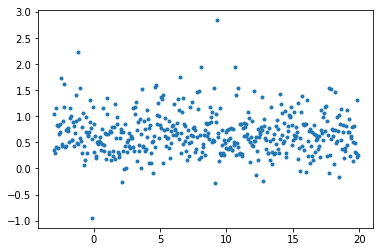

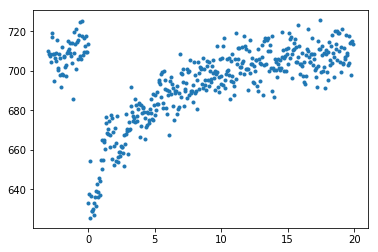

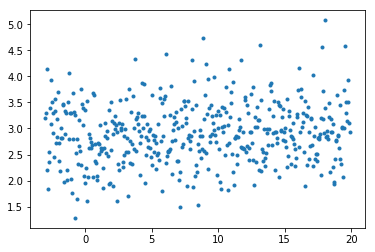

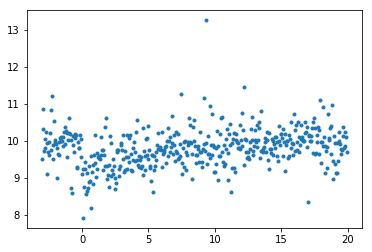

In [112]:
for i in range(4):
    plt.plot(t_bins[:-1],np.diag(beta[i::X.shape[1]][:-1]),'.')
    plt.show()

In [36]:
#now need to implement the tikhonov matrix to constrain standard dev of beta parameters that aren't pump probe
#related and use cross validation to tune them.

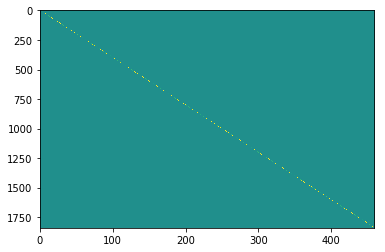

In [37]:
plt.imshow(beta,aspect='auto',clim=(-10,10))

In [38]:
#make ridge kernel
print(beta.shape)
print(big_Y.shape)
print(big_X.shape)

(1840, 460)
(9200, 460)
(9200, 1840)


In [39]:
gamma = 1*(+)

regularization_term = np.dot(np.linalg.inv(np.dot(gamma.transpose(),gamma)),big_X.transpose())


beta = np.dot(pseudo_inv,big_Y) + 

SyntaxError: invalid syntax (<ipython-input-39-01af5d75b94e>, line 1)